# Neuquen Sediment Basin Forward Model with Variable Density

## Import Packages

In [1]:
%matplotlib inline

from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import LightSource
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from fatiando import gridder
from fatiando.mesher import Tesseroid

from tesseroid_density import tesseroid
from tesseroid_relief import TesseroidRelief

## Configure Plots

In [2]:
%matplotlib inline
plt.rcParams['axes.labelsize'] = 9.0 # fontsize of the x any y labels
plt.rcParams['xtick.labelsize'] = 9.0 # fontsize of the tick labels
plt.rcParams['ytick.labelsize'] = 9.0 # fontsize of the tick labels
plt.rcParams['legend.fontsize'] = 9.0
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Computer Modern Roman'
plt.rcParams['text.usetex'] = True # use latex for all text handling
plt.rcParams['text.color'] = '3a3a3a'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.edgecolor'] = '3a3a3a'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['ytick.major.size'] = 2

## Study Area

In [3]:
data = np.load("../data/topography.npy")
lat, lon, topo = data[:, 0], data[:, 1], data[:, 2]
shape = (571, 457)
area = (lat.min(), lat.max(), lon.min(), lon.max())

topography = {'lon': lon, 'lat': lat, 'topo': topo,
              'shape': shape, 'area': area}

/home/santi/.anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/santi/.anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/santi/.anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


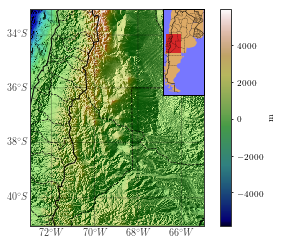

In [4]:
fig, ax = plt.subplots()

bm = Basemap(projection='merc',
             llcrnrlon=area[2],
             llcrnrlat=area[0],
             urcrnrlon=area[3],
             urcrnrlat=area[1],
             resolution='l')

topo = np.ma.masked_array(topography['topo'],
                          np.isnan(topo))
x, y = bm(topography['lon'], topography['lat'])
cmap = plt.cm.gist_earth
vmax = np.abs([np.nanmin(topo), np.nanmax(topo)]).max()
vmin = -vmax
shape = topography['shape']

# Hillshaded topography
ls = LightSource(azdeg=240, altdeg=45)
rgb = ls.shade(topo.reshape(shape), cmap,
               blend_mode='overlay', vmin=vmin, vmax=vmax)
bm.imshow(rgb)

# Proxy image for colorbar
im = bm.imshow(topo.reshape(shape), cmap=cmap)
im.remove()
plt.colorbar(im, label='m')

bm.drawcountries(linewidth=1, color='k')
bm.drawstates(linewidth=0.7, linestyle='--', color='k')
bm.drawcoastlines(color='k')
bm.drawmeridians(np.arange(-80, -50, 2), linewidth=0.5,
                 labels=[False, False, False, True])
bm.drawparallels(np.arange(-50, -30, 2), linewidth=0.5,
                 labels=[True, False, False, False])


# big map
height = "40%"
width = "23.5%"
axins = inset_axes(ax,
                   width=width,
                   height=height,
                   loc=1,
                   borderpad=0)

map2 = Basemap(projection='merc',
               llcrnrlon=360 - 75, llcrnrlat=-56,
               urcrnrlon=360 - 53, urcrnrlat=-21,
               ax=axins)
map2.drawmapboundary(fill_color='#7777ff')
map2.fillcontinents(color='#ddaa66', lake_color='#7777ff')
map2.drawcountries(linewidth=0.5)
map2.drawstates(linewidth=0.3, linestyle='--')

x1, y1 = map2(area[2], area[0])
x2, y2 = map2(area[3], area[1])
rectangle = Rectangle((x1, y1),
                      abs(x2 - x1),
                      abs(y2 - y1),
                      facecolor='C3')
axins.add_patch(rectangle)
plt.show()

## Load sediment thickness data

In [5]:
lat, lon, thickness = np.loadtxt('../data/sediment_thickness.dat',
                                 unpack=True)
thickness = -thickness
shape = (117, 91)

area = (lat.min(), lat.max(), lon.min(), lon.max())

sediments = {'lon': lon, 'lat':lat, 'thickness': thickness,
             'shape': shape, 'area': area}

/home/santi/.anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/santi/.anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


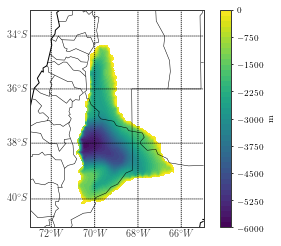

In [6]:
x, y = bm(sediments['lon'], sediments['lat'])
bm.contourf(x.reshape(sediments['shape']),
            y.reshape(sediments['shape']),
            sediments['thickness'].reshape(sediments['shape']),
            50)
bm.drawcountries()
bm.drawstates()
bm.drawcoastlines()
bm.drawmeridians(np.arange(-80, -50, 2), labels=[False, False, False, True])
bm.drawparallels(np.arange(-50, -30, 2), labels=[True, False, False, False])
plt.colorbar(label='m')
plt.show()

## Computation Grid

In [7]:
shape = (159, 163)
area = (-40.9, -33., 286.9, 295.)
lat, lon, height = gridder.regular(area, shape, z=260e3)
grid = {'lat': lat, 'lon': lon, 'height': height,
        'shape': shape, 'area': area}

## Tesseroid Model

In [8]:
thickness = sediments['thickness']
thickness[np.isnan(thickness)] = 0
basin = TesseroidRelief(sediments['area'], sediments['shape'],
                        thickness, 0)

## Forward Computation: Homogeneous vs Variable Density

### Homogeneous Density

In [9]:
fields = 'potential gx gy gz gxx gxy gxz gyy gyz gzz'.split()

basin.addprop('density', [(412 + 275)/2 for i in range(basin.size)])

homogeneous = []
for field in fields:
    lat, lon, height = grid['lat'], grid['lon'], grid['height']
    %time result = getattr(tesseroid, field)(lon, lat, height, basin)
    homogeneous.append(result)

tesseroid_density/tesseroid.py:166: RuntimeWarning: Encountered tesseroid with dimensions smaller than the numerical threshold (1e-6 degrees or 1e-3 m). Ignoring this tesseroid.
  warnings.warn(msg, RuntimeWarning)


CPU times: user 1min 20s, sys: 40 ms, total: 1min 20s
Wall time: 1min 20s
CPU times: user 2min 46s, sys: 36 ms, total: 2min 46s
Wall time: 2min 46s
CPU times: user 2min 48s, sys: 20 ms, total: 2min 48s
Wall time: 2min 48s
CPU times: user 2min 45s, sys: 40 ms, total: 2min 45s
Wall time: 2min 45s
CPU times: user 2min 48s, sys: 28 ms, total: 2min 48s
Wall time: 2min 48s
CPU times: user 2min 50s, sys: 52 ms, total: 2min 50s
Wall time: 2min 50s
CPU times: user 2min 46s, sys: 44 ms, total: 2min 46s
Wall time: 2min 46s
CPU times: user 2min 49s, sys: 32 ms, total: 2min 49s
Wall time: 2min 49s
CPU times: user 2min 49s, sys: 56 ms, total: 2min 49s
Wall time: 2min 49s
CPU times: user 2min 46s, sys: 28 ms, total: 2min 46s
Wall time: 2min 46s


In [10]:
for field, result in zip(fields, homogeneous):
    filename = "results/neuquen-basin/homogeneous/" + field
    np.save(filename, result)

### Variable Density

In [11]:
fields = 'potential gx gy gz gxx gxy gxz gyy gyz gzz'.split()

def density(h):
    return -(412 - 275)/6000.*h + 275

basin.addprop('density', [density for i in range(basin.size)])

variable = []
for field in fields:
    lat, lon, height = grid['lat'], grid['lon'], grid['height']
    %time result = getattr(tesseroid, field)(lon, lat, height, basin)
    variable.append(result)

CPU times: user 4min 49s, sys: 1.38 s, total: 4min 50s
Wall time: 4min 47s
CPU times: user 6min 28s, sys: 2.65 s, total: 6min 30s
Wall time: 6min 25s
CPU times: user 6min 30s, sys: 2.52 s, total: 6min 32s
Wall time: 6min 28s
CPU times: user 6min 26s, sys: 2.54 s, total: 6min 29s
Wall time: 6min 24s
CPU times: user 6min 32s, sys: 2.66 s, total: 6min 34s
Wall time: 6min 29s
CPU times: user 6min 31s, sys: 2.54 s, total: 6min 34s
Wall time: 6min 29s
CPU times: user 7min 42s, sys: 3.4 s, total: 7min 45s
Wall time: 7min 39s
CPU times: user 6min 27s, sys: 2.6 s, total: 6min 29s
Wall time: 6min 24s
CPU times: user 6min 29s, sys: 2.66 s, total: 6min 31s
Wall time: 6min 26s
CPU times: user 6min 33s, sys: 2.98 s, total: 6min 36s
Wall time: 6min 31s


In [12]:
for field, result in zip(fields, variable):
    filename = "results/neuquen-basin/variable/" + field
    np.save(filename, result)

## Plot Results

In [13]:
fields = 'potential gx gy gz gxx gxy gxz gyy gyz gzz'.split()
titles = ["$V$", "$g_x$", "$g_y$", "$g_z$", "$g_{xx}$", "$g_{xy}$",
          "$g_{xz}$", "$g_{yy}$", "$g_{yz}$", "$g_{zz}$"]
labels = "J/kg mGal mGal mGal Eotvos Eotvos Eotvos Eotvos Eotvos Eotvos".split()
lat, lon, height = grid['lat'], grid['lon'], grid['height']
shape = grid['shape']
area = grid['area']

variable, homogeneous = [], []
for field in fields:
    filename = "results/neuquen-basin/homogeneous/" + field + ".npy"
    homogeneous.append(np.load(filename))
    filename = "results/neuquen-basin/variable/" + field + ".npy"
    variable.append(np.load(filename))

### Results with Homogeneous Density

/home/santi/.anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/santi/.anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3572: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


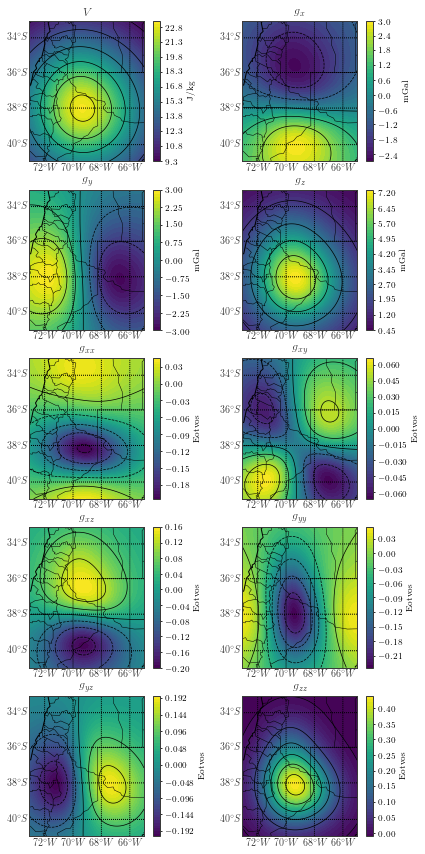

In [14]:
fig, axes = plt.subplots(5, 2, figsize=(7, 15))
axes = axes.ravel()

for result, title, label, ax in zip(homogeneous, titles, labels, axes):
    
    bm = Basemap(projection='merc',
                 llcrnrlon=area[2],
                 llcrnrlat=area[0],
                 urcrnrlon=area[3],
                 urcrnrlat=area[1],
                 resolution='l', ax=ax)
    
    x, y = bm(lon, lat)
    
    cb = bm.contourf(x.reshape(shape), y.reshape(shape),
                     result.reshape(shape), 50)
    bm.contour(x.reshape(shape), y.reshape(shape),
               result.reshape(shape), 5, colors='k',
               linewidths=0.7)
    bm.drawcountries()
    bm.drawstates()
    bm.drawcoastlines()
    bm.drawmeridians(np.arange(-80, -50, 2),
                     labels=[False, False, False, True])
    bm.drawparallels(np.arange(-50, -30, 2),
                     labels=[True, False, False, False])
    plt.colorbar(cb, ax=ax, label=label)
    ax.set_title(title)

plt.show()

### Results with Variable Density

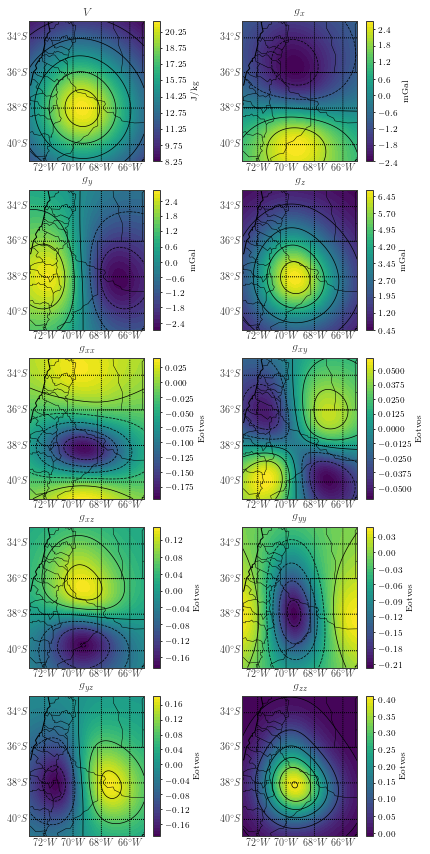

In [15]:
fig, axes = plt.subplots(5, 2, figsize=(7, 15))
axes = axes.ravel()

for result, title, label, ax in zip(variable, titles, labels, axes):
    
    bm = Basemap(projection='merc',
                 llcrnrlon=area[2],
                 llcrnrlat=area[0],
                 urcrnrlon=area[3],
                 urcrnrlat=area[1],
                 resolution='l', ax=ax)
    
    x, y = bm(lon, lat)
    
    cb = bm.contourf(x.reshape(shape), y.reshape(shape),
                     result.reshape(shape), 50)
    bm.contour(x.reshape(shape), y.reshape(shape),
               result.reshape(shape), 5, colors='k',
               linewidths=0.7)
    bm.drawcountries()
    bm.drawstates()
    bm.drawcoastlines()
    bm.drawmeridians(np.arange(-80, -50, 2),
                     labels=[False, False, False, True])
    bm.drawparallels(np.arange(-50, -30, 2),
                     labels=[True, False, False, False])
    plt.colorbar(cb, ax=ax, label=label)
    ax.set_title(title)

plt.show()